# Final project - MHPC 2019-2020

In this notebook we use the following package versions:
- Numpy: version 1.18.1
- Matplotlib: version 3.1.3
- Scipy: 1.4.1

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import *
from scipy.integrate import *

The Allen–Cahn equation describes the time evolution of a scalar field $\eta(x,t)$ on a 1d domain $\Omega = \{x \in [0,1]\}$ during a time interval $t \in [0,T]$:

$$
\partial_t \eta - \varepsilon^2 \partial_{xx}\eta + \partial_x \left[ f(\eta) \right] = 0, \qquad \partial_x \eta(0, t) = \partial_x \eta(1, t) = 0, \qquad \eta(x,0) = \eta_0(x)
$$

where $\varepsilon$ is the characteristic width of the phase transition, $\eta_0$ is the initial condition, and $f$ is a double-well potential:

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa). Any other value for $\eta$ is unstable, and the equation will pull that region towards either $0$ or $1$.

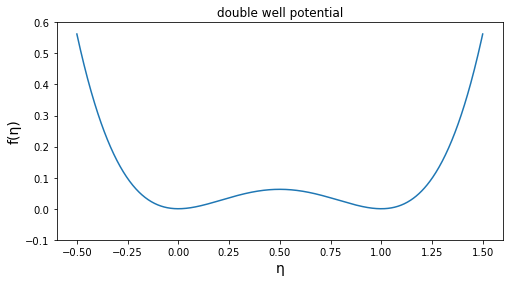

In [2]:
def f(eta):
    return eta * eta * (eta - 1)**2 

plt.figure(figsize = (8,4))
_ = plt.plot(np.linspace(-0.5,1.5,1025), f(np.linspace(-0.5,1.5,1025)))
_ = plt.xlabel("\u03B7", fontsize = 14)
_ = plt.ylabel("f(\u03B7)", fontsize = 14)
_ = plt.title("double well potential")
_ = plt.ylim((-0.1, 0.6))

Discretisation of this problem can be done by finite difference in time. 

For example, for a **fully explicit discretisation** in time (**forward Euler**) we split the interval $[0,T]$ in n_steps intervals, of dimension $\Delta t = T / $ n_steps.  
Given the solution at time $t[k] = k\, \Delta t$, it i possible to compute the next solution at time $t[k+1]$ as:

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \partial_{xx} \eta_k - \Delta t \partial_x [f(\eta_k)]
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \partial_{xx} \eta_k$ implicitly, and keep the term $- \partial_x[f(\eta_k)]$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \partial_{xx} \eta_k = \eta_{k} - \Delta t \partial_x [f(\eta_k)]
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.


Moving to a **hybrid implicit + explicit discretization** in time (**backward Euler** for the second spatial derivative term and **forward Euler** for the potential term),  
given a set of basis functions $v_i$, and representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big[(v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big] \eta^j_{k+1} = \big[(v_i, v_j) \eta^j_{k} - \Delta t (v_i, \partial_x[f(\eta_k)])\big]
$$

where a sum is implied over $j$ on both the left hand side and the right hand side. This results in a linear system

$$
A x = b
$$

where

$$
x = \eta_{k+1}
$$

while

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = (v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j') 
$$

and

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t \partial_x [f(\eta_k^j)] \big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $\partial_x [f(\eta)]$.

To solve this problem numerically, we proceed in three steps.

## Step 1

As requested from the exercise, we first define a function that computes the first derivative of the potential function:

In [3]:
def F(eta):
    '''
    Computes the first derivative of the double-well potential function
    '''
    return 2.*eta*(eta - 1)**2 + 2.*(eta - 1)*eta**2

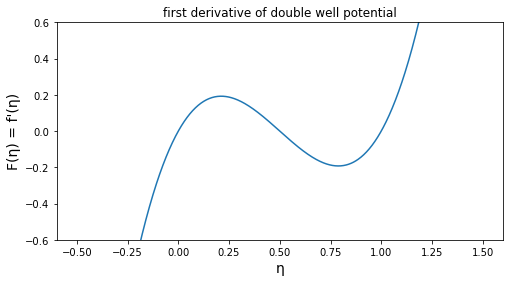

In [4]:
plt.figure(figsize = (8,4))
_ = plt.plot(np.linspace(-0.5,1.5,1025), F(np.linspace(-0.5,1.5,1025)))
_ = plt.xlabel("\u03B7", fontsize = 14)
_ = plt.ylabel("F(\u03B7) = f'(\u03B7)", fontsize = 14)
_ = plt.title("first derivative of double well potential")
_ = plt.ylim((-0.6, 0.6))

Then we define a function to compute the piecewise polynomial basis functions for our space of interpolating functions in the domain $\Omega$:

In [5]:
def compute_basis_functions(support_points, degree):
    '''
    Returns a list of interpolatory spline basis functions 
    given ndofs support points and the degree of the polynomial basis
    '''
    
    basis = []

    for i in range(len(support_points)):
        c = support_points*0
        c[i] = 1
        bi = PPoly.from_spline(splrep(support_points, c, k = degree))
        basis.append(bi)
    
    return basis

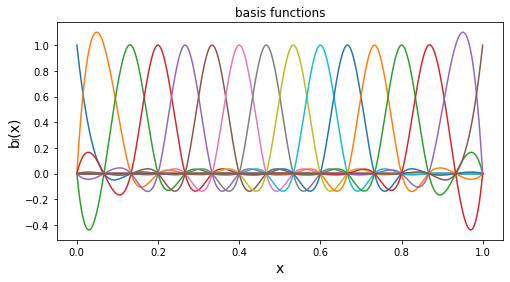

In [6]:
# Basis functions for ndofs = 16 (equidistant support points) and degree = 3

plt.figure(figsize = (8,4))

for i in range(16):
    _ = plt.plot( np.linspace(0,1,1025), compute_basis_functions( np.linspace(0,1,16), 3 )[i]( np.linspace(0,1,1025) ) )
    
_ = plt.xlabel("x", fontsize = 14)
_ = plt.ylabel("b\u2097(x)", fontsize = 14)
_ = plt.title("basis functions")

Next we define a function to compute the global quadrature and global weights used for integration: 

In [7]:
def compute_global_quadrature(basis, n_gauss_quadrature_points):
    
    intervals = np.unique(basis[0].x)

    qp, w = np.polynomial.legendre.leggauss(n_gauss_quadrature_points)  # n_gauss_quadrature_points will be degree + 1

    # rescale points, weights to work in the interval [0,1] (i.e. our x domain) rather than the default [-1,1]
    
    qp = (qp+1)/2
    w /= 2

    h = np.diff(intervals)
    global_quadrature = np.array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = np.array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    return global_quadrature, global_weights

Finally, we define a function that computes the matrices M and K:

In [8]:
def compute_system_matrices(basis, global_quadrature, global_weights):
    '''
    Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j') and return them
    '''
    
    dbasis = [bi.derivative(1) for bi in basis]
    
    Bq = np.array([basis[i](global_quadrature) for i in range(len(basis))]).T
    dBq = np.array([dbasis[i](global_quadrature) for i in range(len(basis))]).T
    
    # return M, K
    return np.einsum('qi, q, qj', Bq, global_weights, Bq), np.einsum('qi, q, qj', dBq, global_weights, dBq)

## Step 2

In step 2, we first define a function that numerically solve the Allen-Cahan equation:

In [9]:
def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    '''
    Numerically solve Allen-Cahan
    '''
    support_points = np.linspace(0,1,ndofs)

    basis = compute_basis_functions(support_points, degree)
    
    global_quadrature, global_weights = compute_global_quadrature(basis, degree + 1)
    
    M, K = compute_system_matrices(basis, global_quadrature, global_weights)
    
    T = 1.0  # time domain: [0, T]; here T = 1.0
    
    eta = np.zeros((int(T/dt) + 1, ndofs))
    
    A = M + eps*eps*dt*K
    
    eta_now = eta_0_function(support_points)
    
    eta[0,:] = eta_now
    
    for i in range(1, int(T/dt) + 1):
    
        b = M.dot(eta_now - dt * F(eta_now))
                   
        eta_later = np.linalg.solve(A, b)
                     
        eta[i,:] = eta_later
                   
        eta_now = eta_later
                   
    return eta, basis

Then we define a function to plot the time evolution with some temporal stride:

In [10]:
def plot_solution(eta, basis, stride, resolution, legend = False, title = ""):

    x = np.linspace(0,1,resolution)
    
    B = np.zeros((resolution, len(basis)))
    
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
        
    eta_plot = eta[::stride].dot(B.T)
    
    T = 1.0  # time domain: [0, T]; here T = 1.0
    
    for i in range(eta_plot.shape[0]):
        plt.plot(x, eta_plot[i,:], label = "t = " + str(i*stride*T/(eta.shape[0]-1)))
        
    plt.xlabel("x", fontsize = 14)
    plt.ylabel("\u03B7\u209C(x)", fontsize = 14)
    plt.title("solution \u03B7\u209C(x)" + title)
    
    if (legend == True):
        plt.legend()

Examples of solutions:

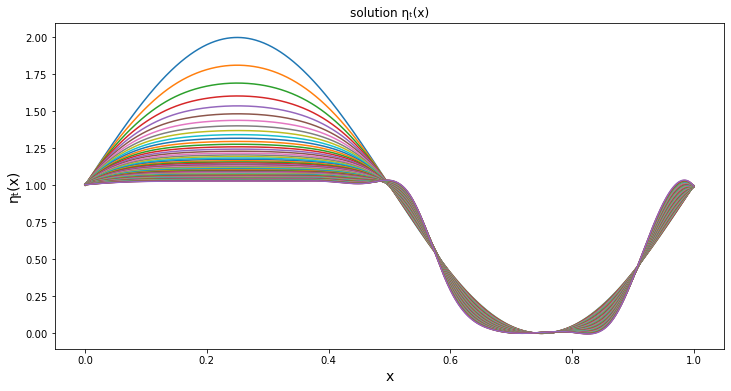

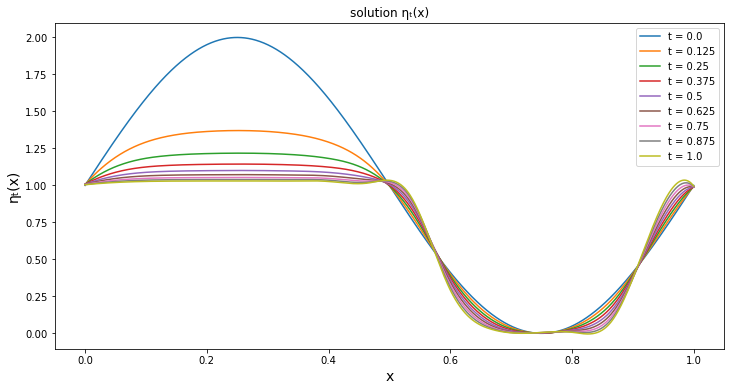

In [11]:
def eta_0_function(x):
    return np.sin(2.*np.pi*x) + 1.

eps = 0.01
dt = 0.015625
ndofs = 16
degree = 3

eta, basis = solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree)

stride = 1
resolution = 1025

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, resolution)

stride = 8

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, resolution, legend = True)

## Step 3

For step 3, we first define a function that plot the solution at $t = 1$ and (optionally) $t = 0$:

In [12]:
def plot_solution_final(eta, basis, resolution, initial = False, title = ""):
    # plot eta[-1,:], on x = linspace(0,1,resolution)
    x = np.linspace(0,1,resolution)
    
    B = np.zeros((resolution, len(basis)))
    
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
        
    plt.plot(x, eta[-1,:].dot(B.T), label = "t = 1")
        
    if (initial == True):
        plt.plot(x, eta[0,:].dot(B.T), label = "t = 0")    
        
    plt.legend()
    plt.xlabel("x", fontsize = 14)
    plt.ylabel("\u03B7\u209C(x)", fontsize = 14)
    plt.title("solution \u03B7\u209C(x)" + title)

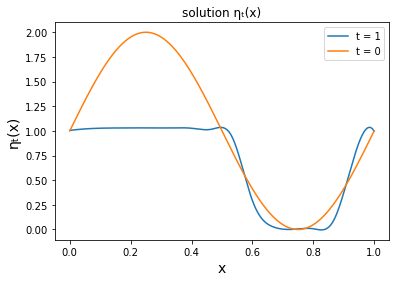

In [13]:
plot_solution_final(eta, basis, resolution, True)

We then create a function that plots all $t = 1$ solutions at fixed $\epsilon$ and degree, varying $\Delta t$ and the number of degrees of freedom: 

In [14]:
def solutions(eps, degree, resolution, initial = False):
    
    dt = [.25, .125, .0625, .03125, .015625]
    ndofs = [16, 32, 64, 128]
    
    print("\t\t\t\t\t\t \033[1m SOLUTION AT eps = " + str(eps) + ", degree = " + str(degree) + " \033[0m \n")

    plt.figure(figsize = (20,20))

    for i in range(len(dt)):
        for j in range(len(ndofs)):
            
            eta, basis = solve_allen_cahan(eta_0_function, eps, dt[i], ndofs[j], degree)
            
            plt.subplot(len(dt), len(ndofs), int(len(ndofs)*i + j + 1))
            plot_solution_final(eta, basis, resolution, initial = initial, title = " at dt = " + str(dt[i]) + ", ndofs = " + str(ndofs[j]))
        
    plt.tight_layout()

We can now produce all required plots:

						  SOLUTION AT eps = 0.01, degree = 1  



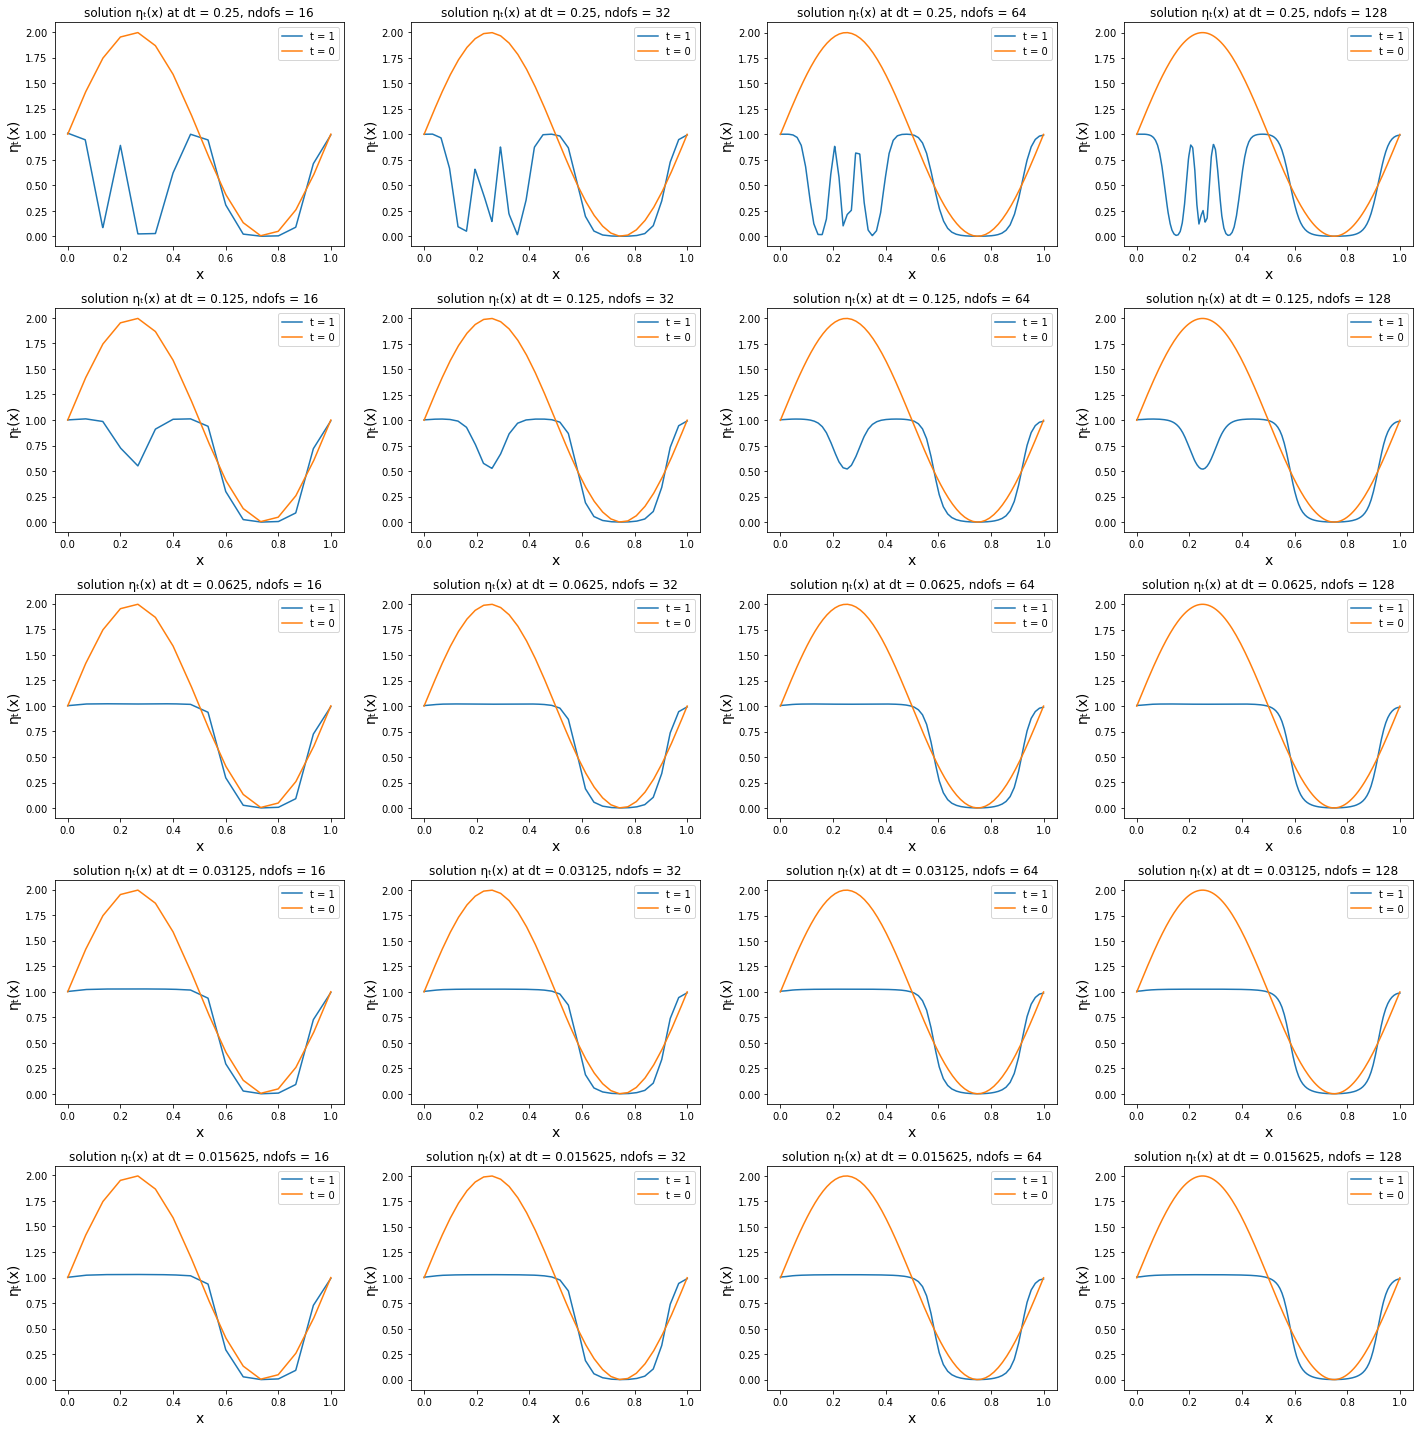

In [15]:
eps = 0.01
degree = 1
resolution = 1025

solutions(eps, degree, resolution, initial = True)

						  SOLUTION AT eps = 0.001, degree = 1  



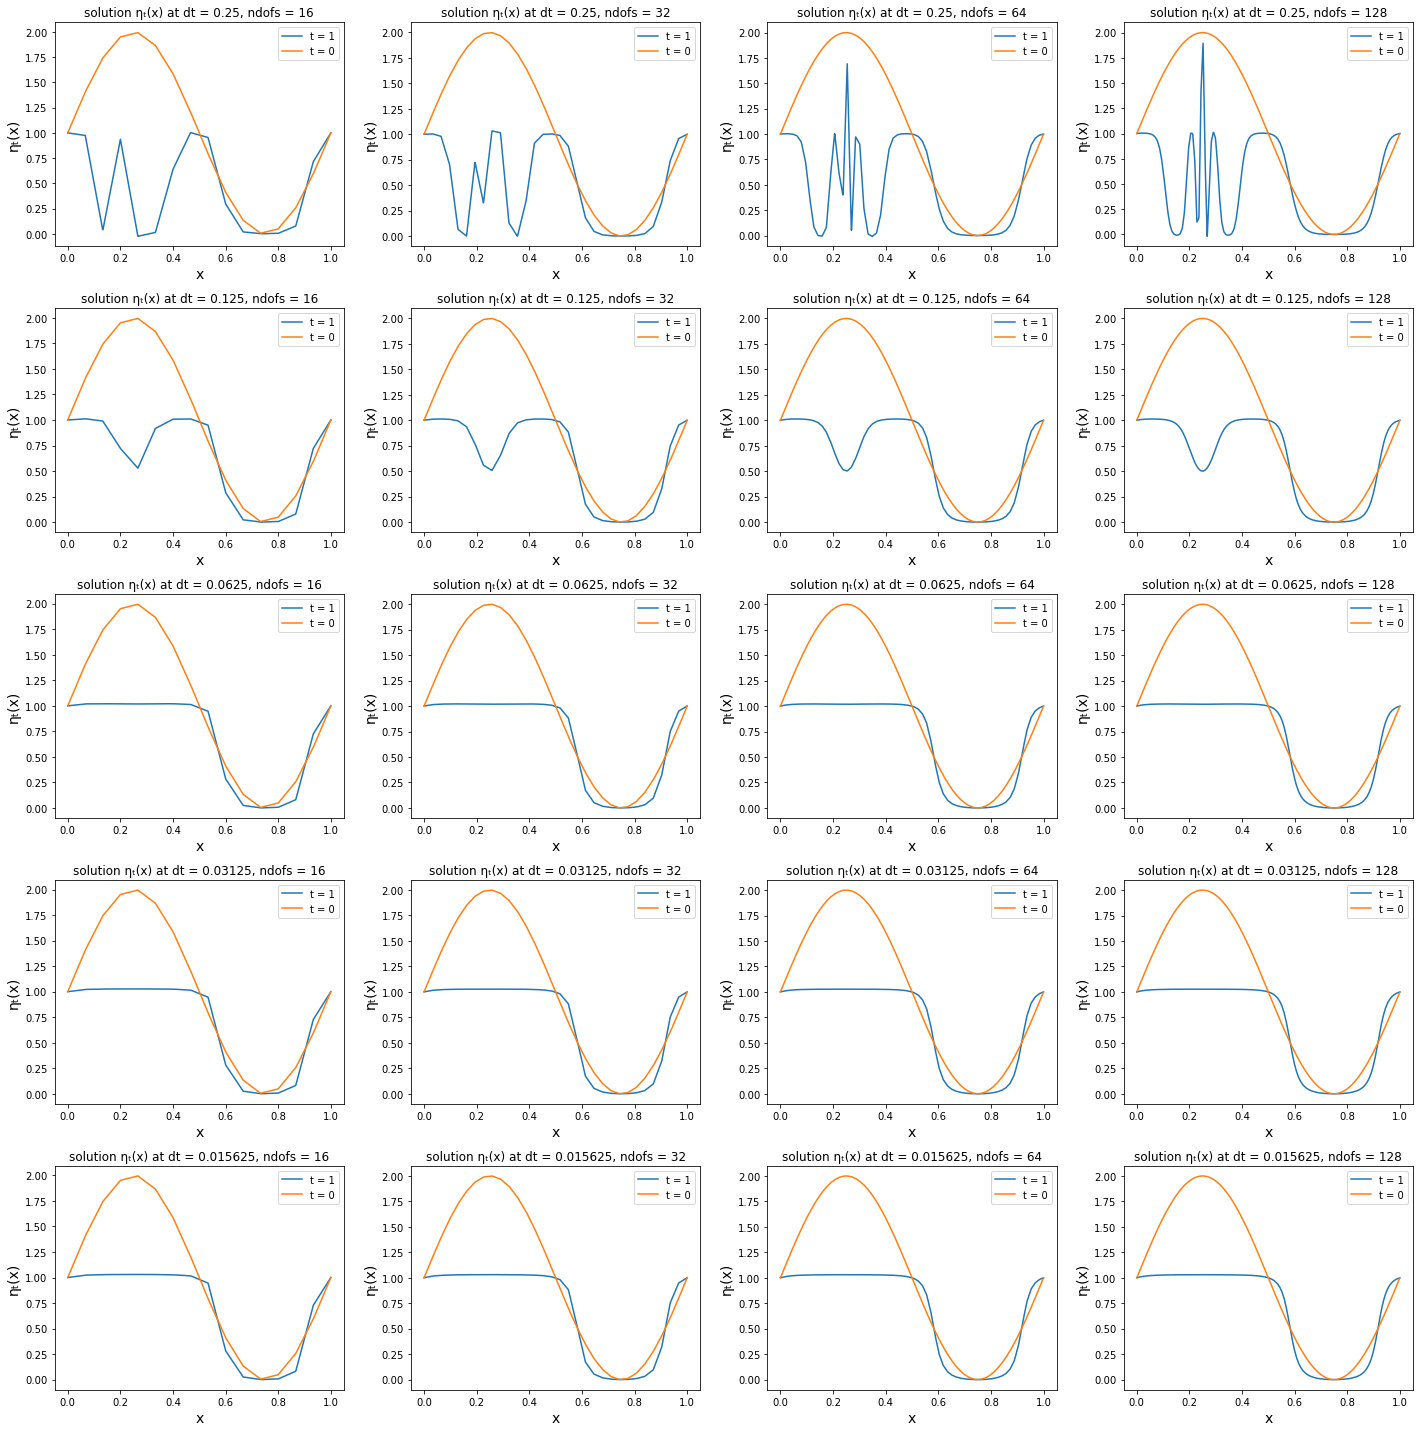

In [16]:
eps = 0.001
degree = 1
resolution = 1025

solutions(eps, degree, resolution, initial = True)

						  SOLUTION AT eps = 0.01, degree = 2  



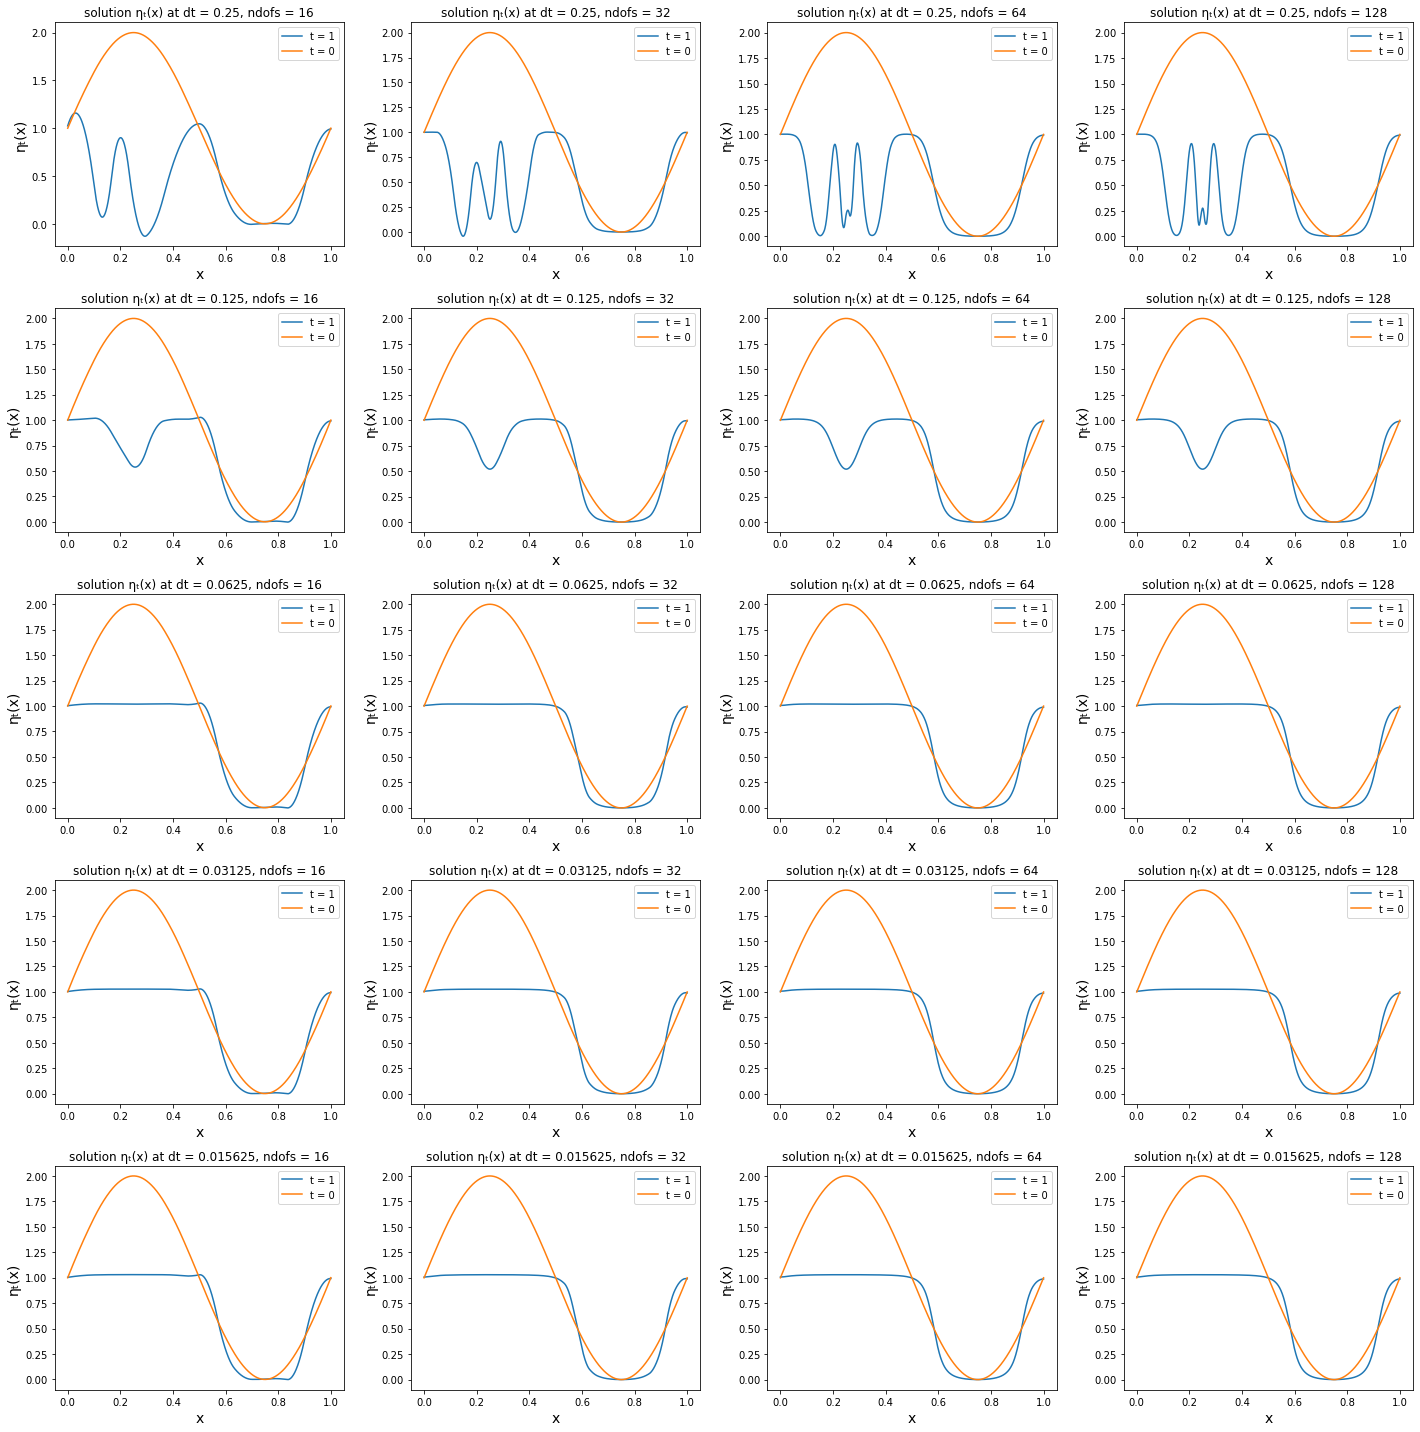

In [17]:
eps = 0.01
degree = 2
resolution = 1025

solutions(eps, degree, resolution, initial = True)

						  SOLUTION AT eps = 0.001, degree = 2  



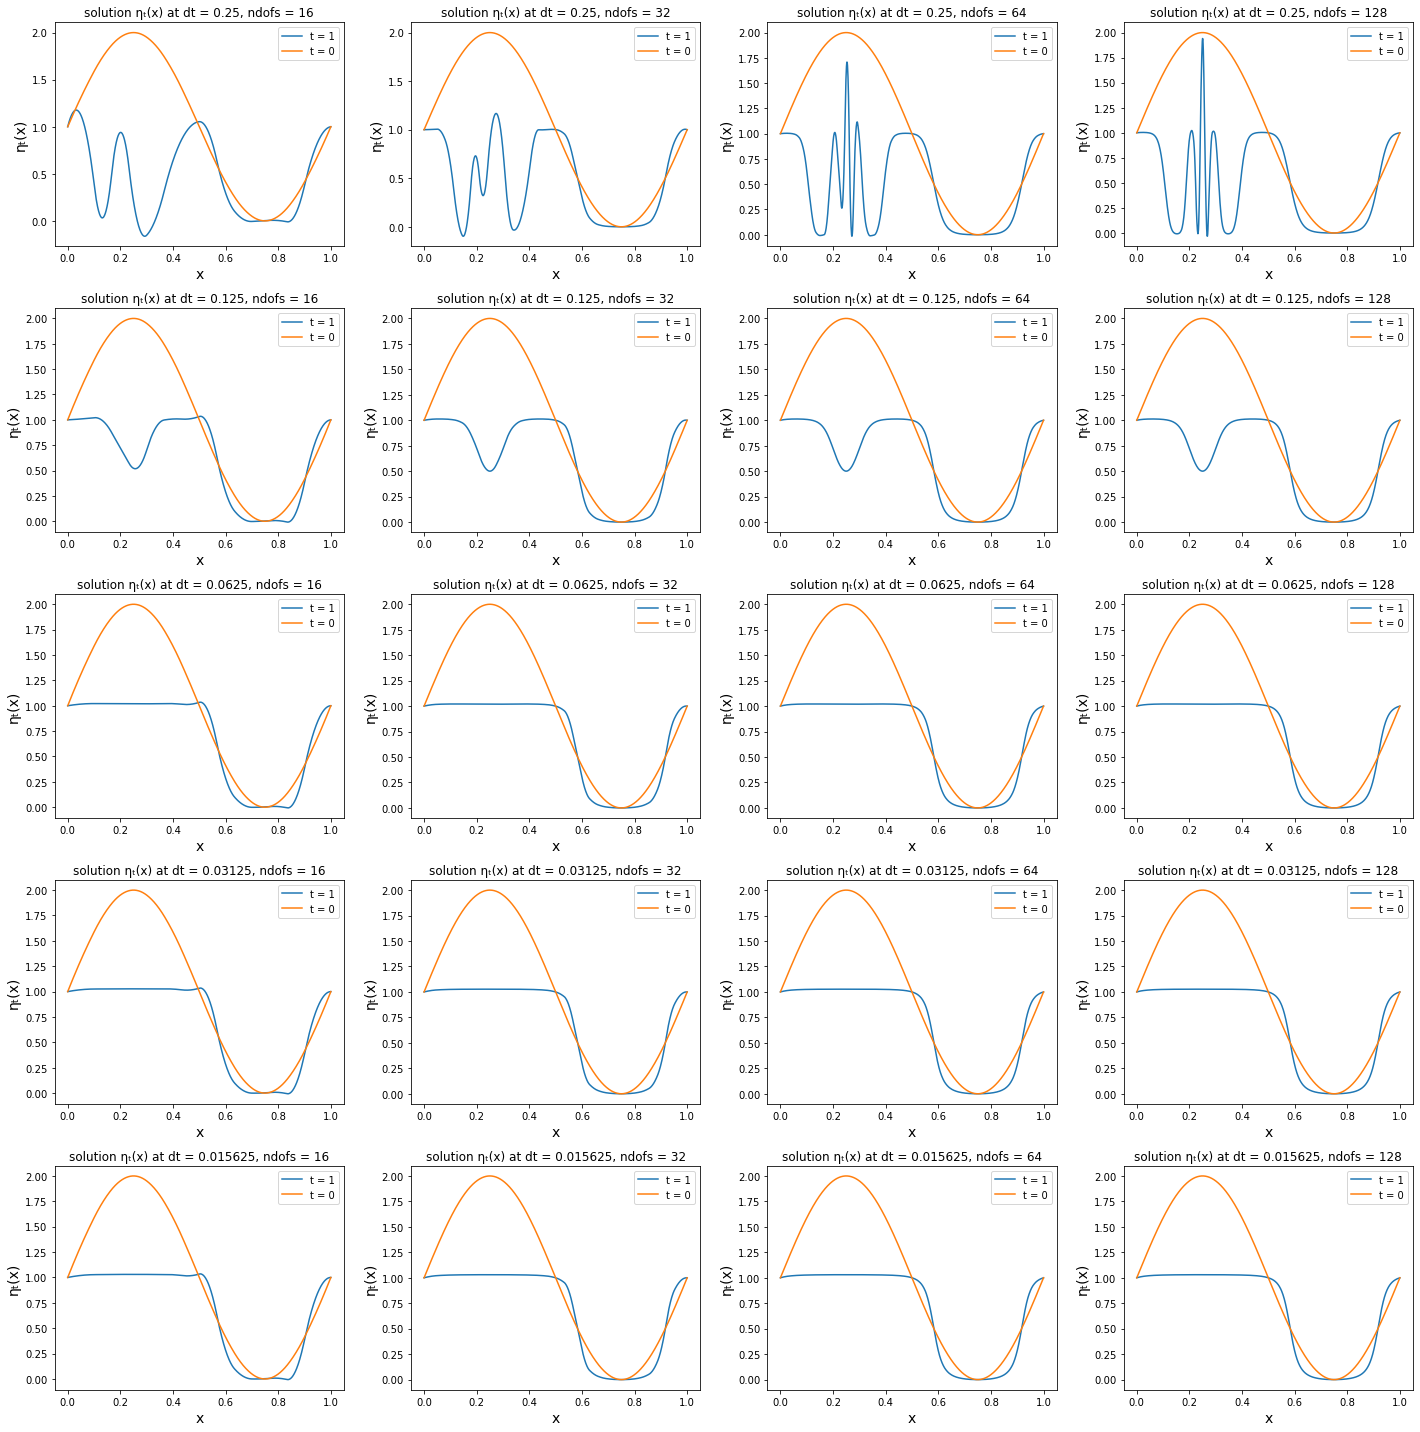

In [18]:
eps = 0.001
degree = 2
resolution = 1025

solutions(eps, degree, resolution, initial = True)

						  SOLUTION AT eps = 0.01, degree = 3  



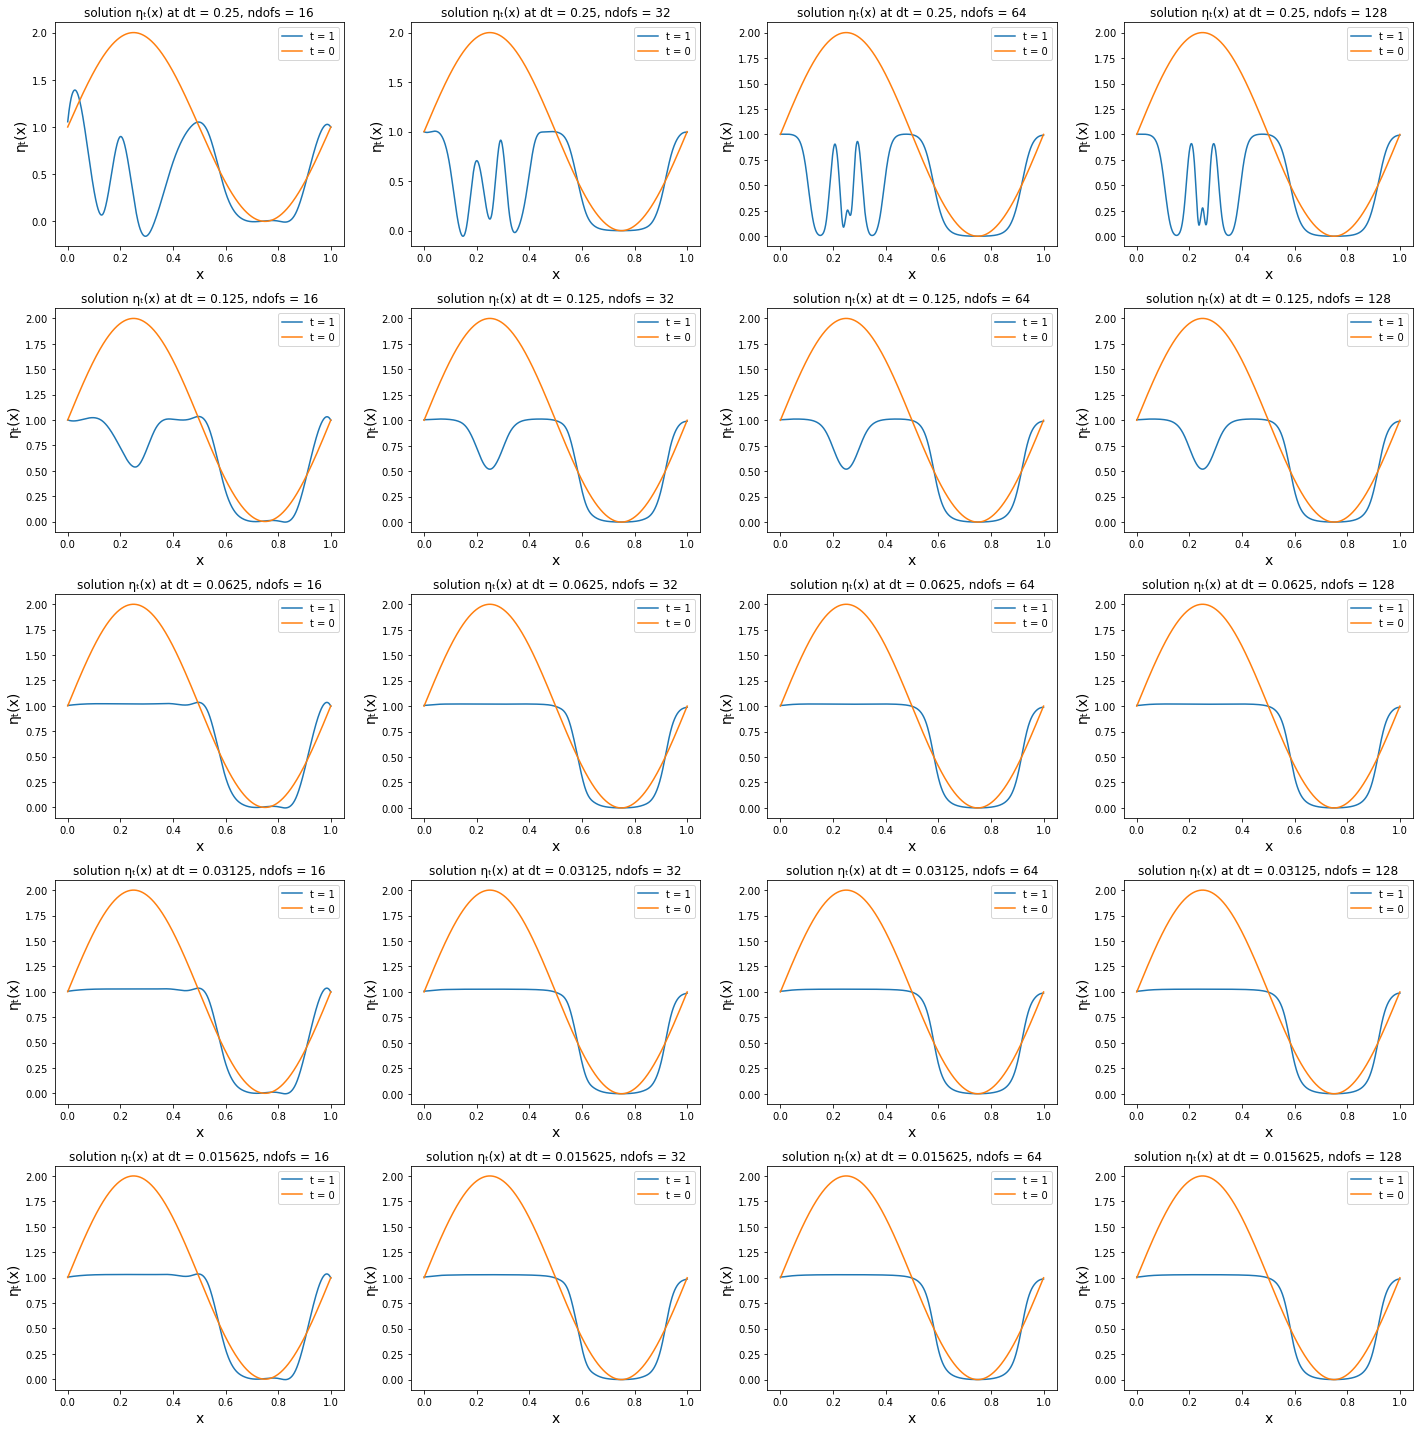

In [19]:
eps = 0.01
degree = 3
resolution = 1025

solutions(eps, degree, resolution, initial = True)

						  SOLUTION AT eps = 0.001, degree = 3  



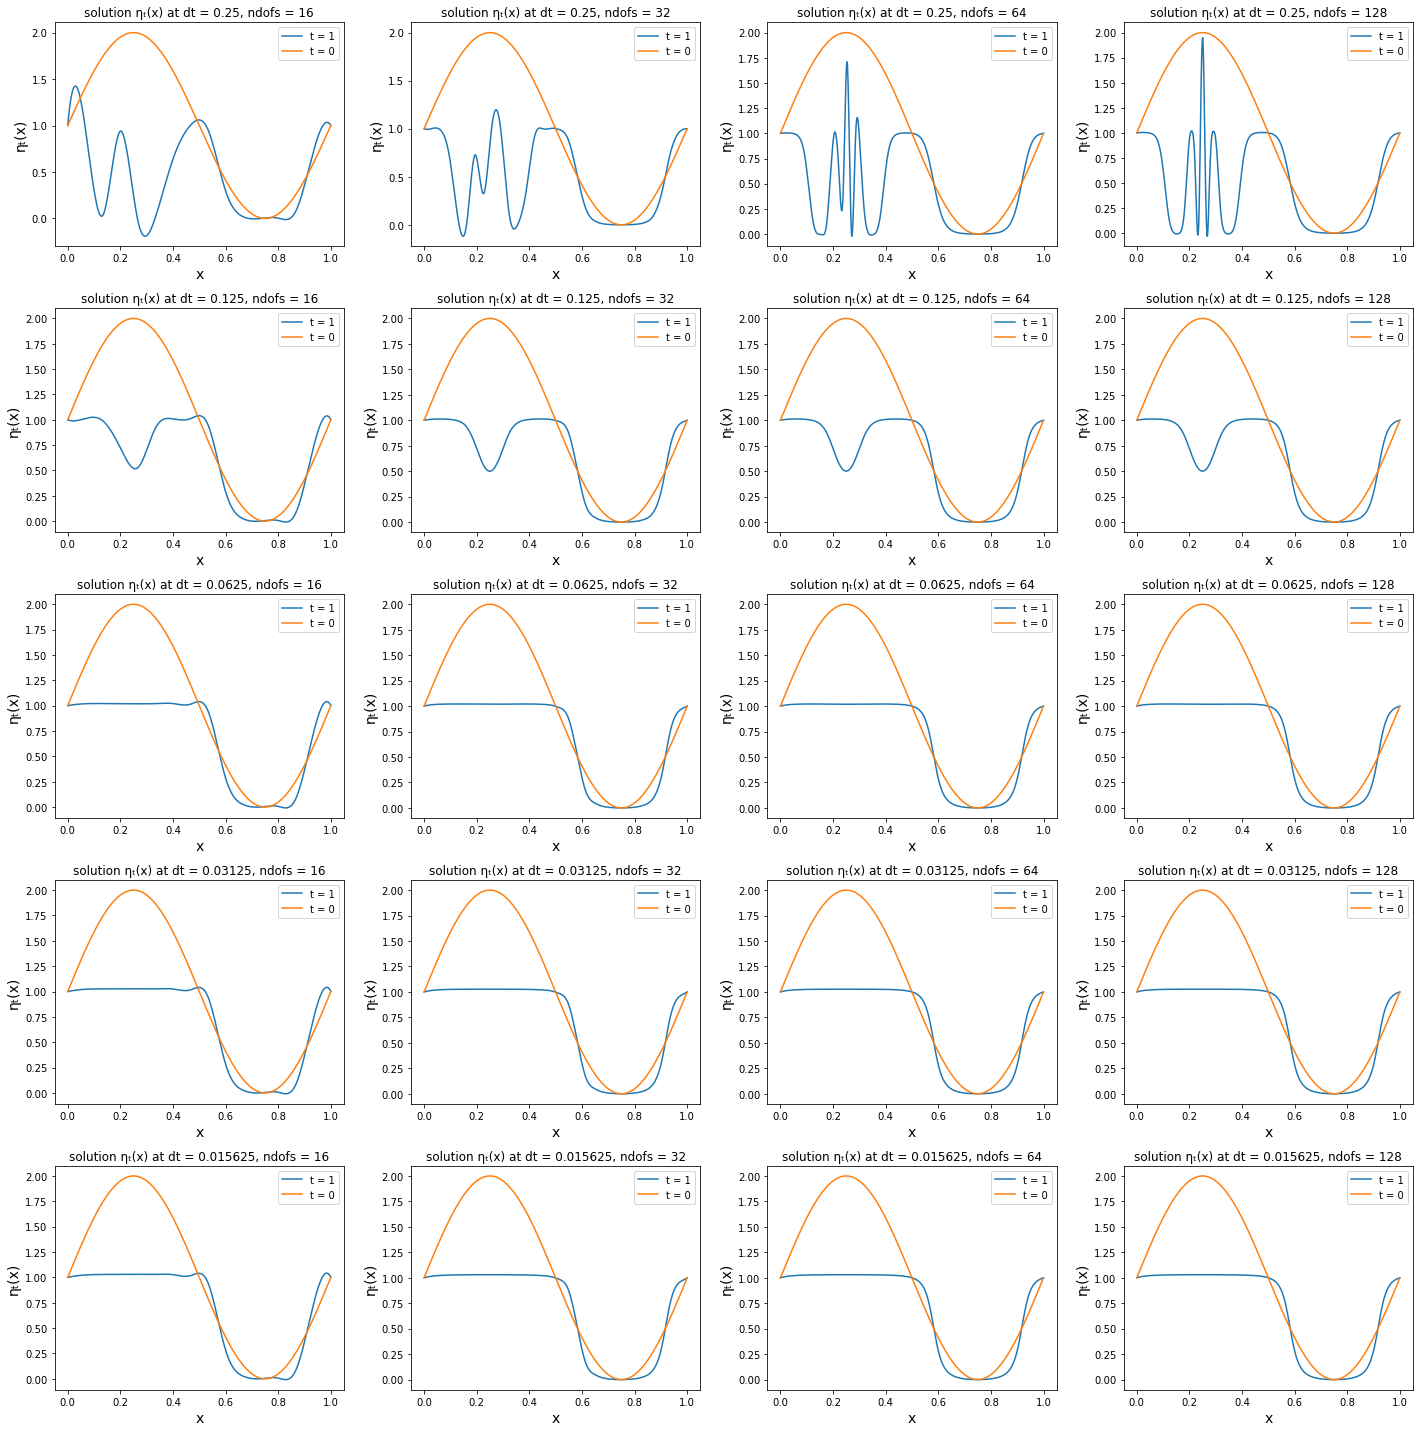

In [20]:
eps = 0.001
degree = 3
resolution = 1025

solutions(eps, degree, resolution, initial = True)

From these plots we notice the following things:
- The numerical solution (at least for small $\Delta t$) correctly tends to the expected solution given our potential (i.e. $1$ for $\eta > 0.5$, $0$ for $\eta < 0.5$);
- Increasing the number of degrees of freedom while keeping $\Delta t$ constant, the final solution gets smoother as expected;
- The solution gets smoother also when increasing the degree, again as expected;
- For large $\Delta t$ the solution does not always converge: this is because the forward Euler method is not stable for all range of parameters (it is conditionally stable), and also because time derivative approximations become less precise for large $\Delta t$.

## Step 4

For the last, optional part of the assignment, we should consider an **implicit** time discretization (**backward Euler**) also for the non-linear term, i.e. the one involving $\partial_x f(\eta) = F(\eta)$.  
This means that we should replace $\eta_k$ with $\eta_{k+1}$ in such term, which leads to:

$$
\big[(v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big] \eta^j_{k+1} + \Delta t (v_i, \partial_x[f(\eta_{k+1})]) = (v_i, v_j) \eta^j_{k}
$$

that is

$$
(v_i, v_j) \big[ \eta^j_{k+1} + \Delta t \partial_x [f(\eta_{k+1}^j)] \big] + \Delta t \varepsilon^2  (v_i', v_j') \eta^j_{k+1} = (v_i, v_j) \eta^j_{k}
$$


where a sum is implied over $j$ on both the left hand side and the right hand side. We therefore have to deal with a non-linear system at each time step. This can be done with the Newton method, already implemented in the Scipy library.

To this purpose, we first define a function that solves our non-linear equation numerically:

In [21]:
def nonlinear_solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    
    support_points = np.linspace(0,1,ndofs)
    basis = compute_basis_functions(support_points, degree)
    
    global_quadrature, global_weights = compute_global_quadrature(basis, degree + 1)
    
    M, K = compute_system_matrices(basis, global_quadrature, global_weights)
    
    T = 1.0  # time domain: [0, T]; here T = 1.0
    
    eta = np.zeros((int(T/dt) + 1, ndofs))
    
    eta_now = eta_0_function(support_points)
    
    eta[0,:] = eta_now
    
    for i in range(1, int(T/dt) + 1):
        
        eta_later = scipy.optimize.newton(lambda x : M.dot(x + dt*F(x)) + eps*eps*dt*K.dot(x) - M.dot(eta_now), eta_now, maxiter = 200)
                     
        eta[i,:] = eta_later
                   
        eta_now = eta_later
                   
    return eta, basis

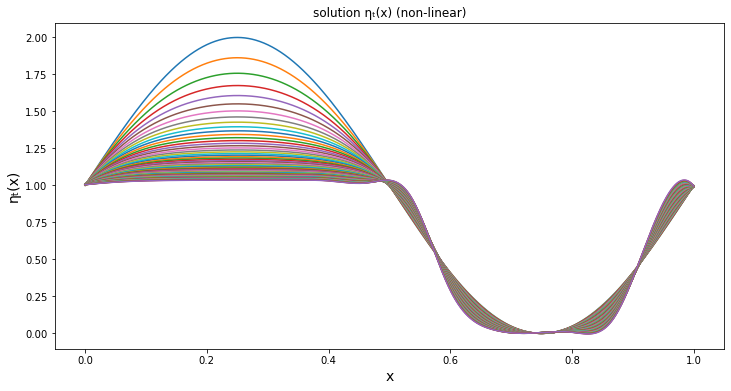

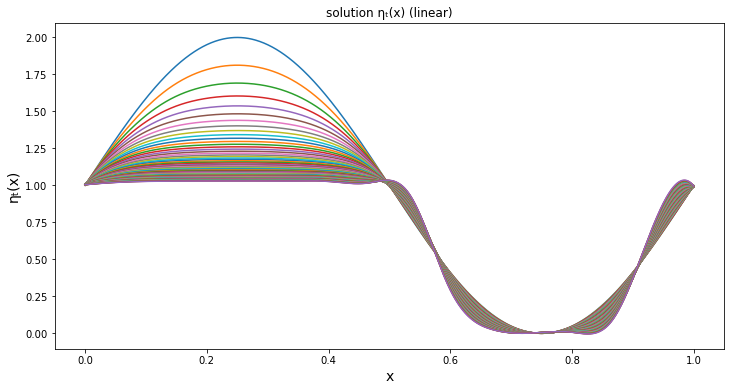

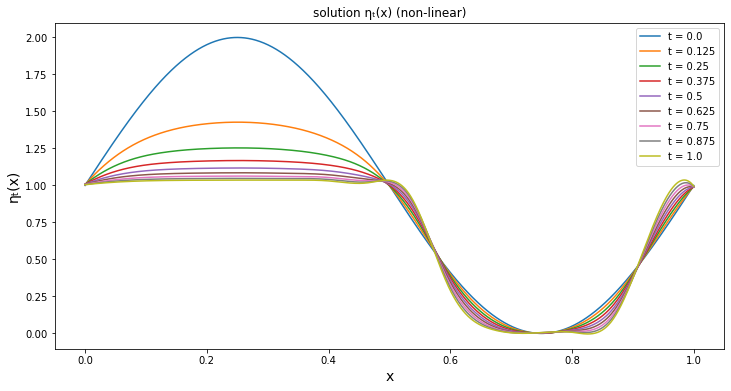

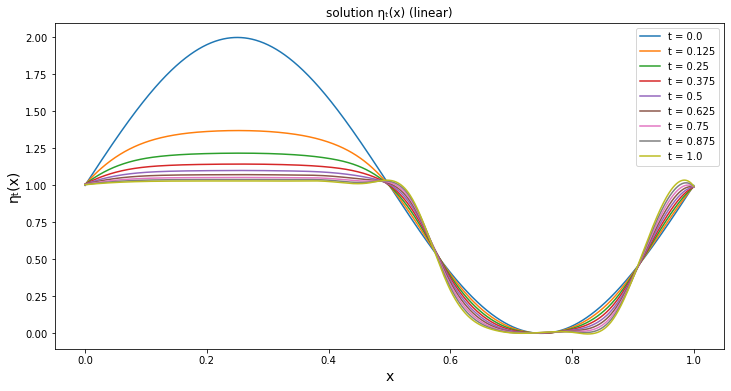

In [22]:
eps = 0.01
dt = 0.015625
ndofs = 16
degree = 3

nonlinear_eta, nonlinear_basis = nonlinear_solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree)
eta, basis = solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree)

stride = 1
resolution = 1025

plt.figure(figsize = (12,6))
plot_solution(nonlinear_eta, nonlinear_basis, stride, resolution, title = " (non-linear)")

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, resolution, title = " (linear)")

stride = 8

plt.figure(figsize = (12,6))
plot_solution(nonlinear_eta, nonlinear_basis, stride, resolution, legend = True, title = " (non-linear)")

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, resolution, legend = True, title = " (linear)")

Then we define a function to make all relevant plots:

In [23]:
def nonlinear_solutions(eps, degree, resolution, initial = False):
    
    dt = [.25, .125, .0625, .03125, .015625]
    ndofs = [16, 32, 64, 128]
    
    print("\t\t\t\t\t\t \033[1m NON-LINEAR SOLUTION AT eps = " + str(eps) + ", degree = " + str(degree) + " \033[0m \n")

    plt.figure(figsize = (20,20))

    for i in range(len(dt)):
        for j in range(len(ndofs)):
            
            eta, basis = nonlinear_solve_allen_cahan(eta_0_function, eps, dt[i], ndofs[j], degree)
            
            plt.subplot(len(dt), len(ndofs), int(len(ndofs)*i + j + 1))
            plot_solution_final(eta, basis, resolution, initial = initial, title = " at dt = " + str(dt[i]) + ", ndofs = " + str(ndofs[j]))
        
    plt.tight_layout()

Here we present all the requested plots:

						  NON-LINEAR SOLUTION AT eps = 0.01, degree = 1  



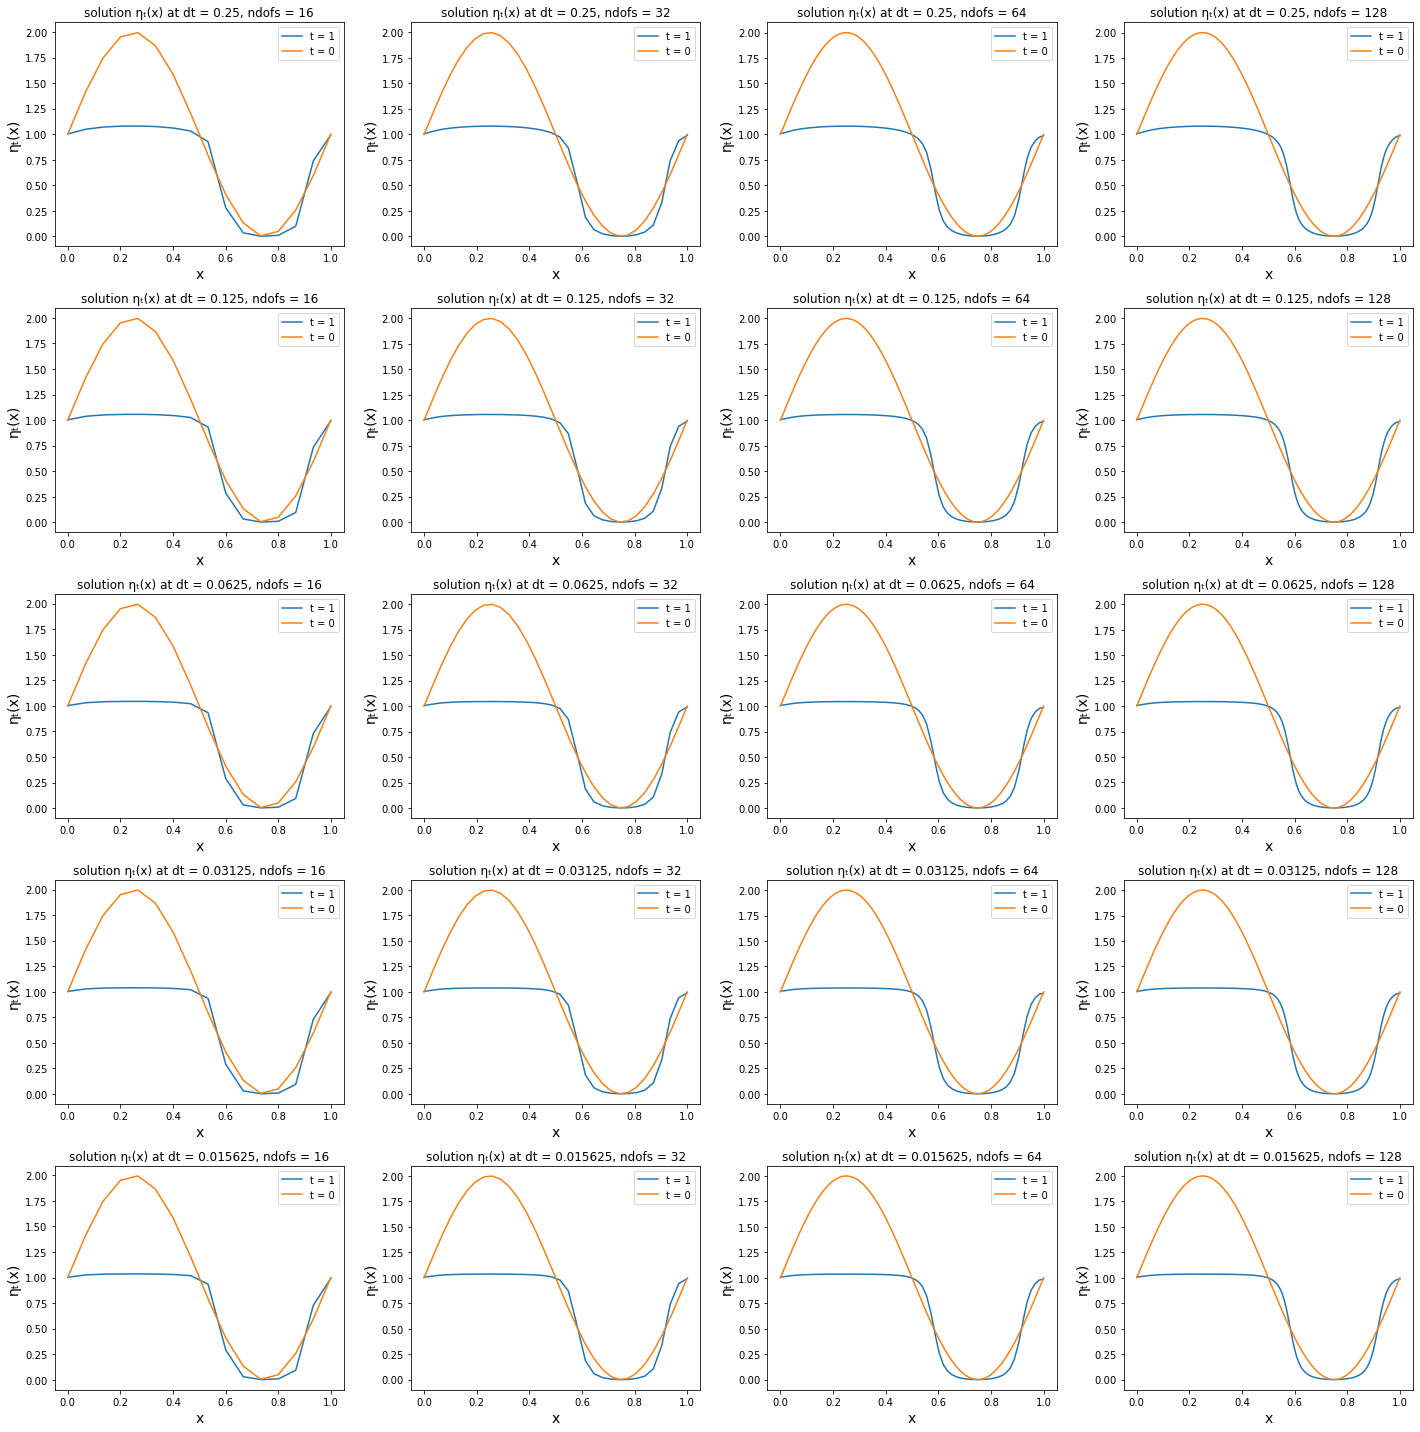

In [24]:
eps = 0.01
degree = 1
resolution = 1025

nonlinear_solutions(eps, degree, resolution, initial = True)

						  NON-LINEAR SOLUTION AT eps = 0.001, degree = 1  



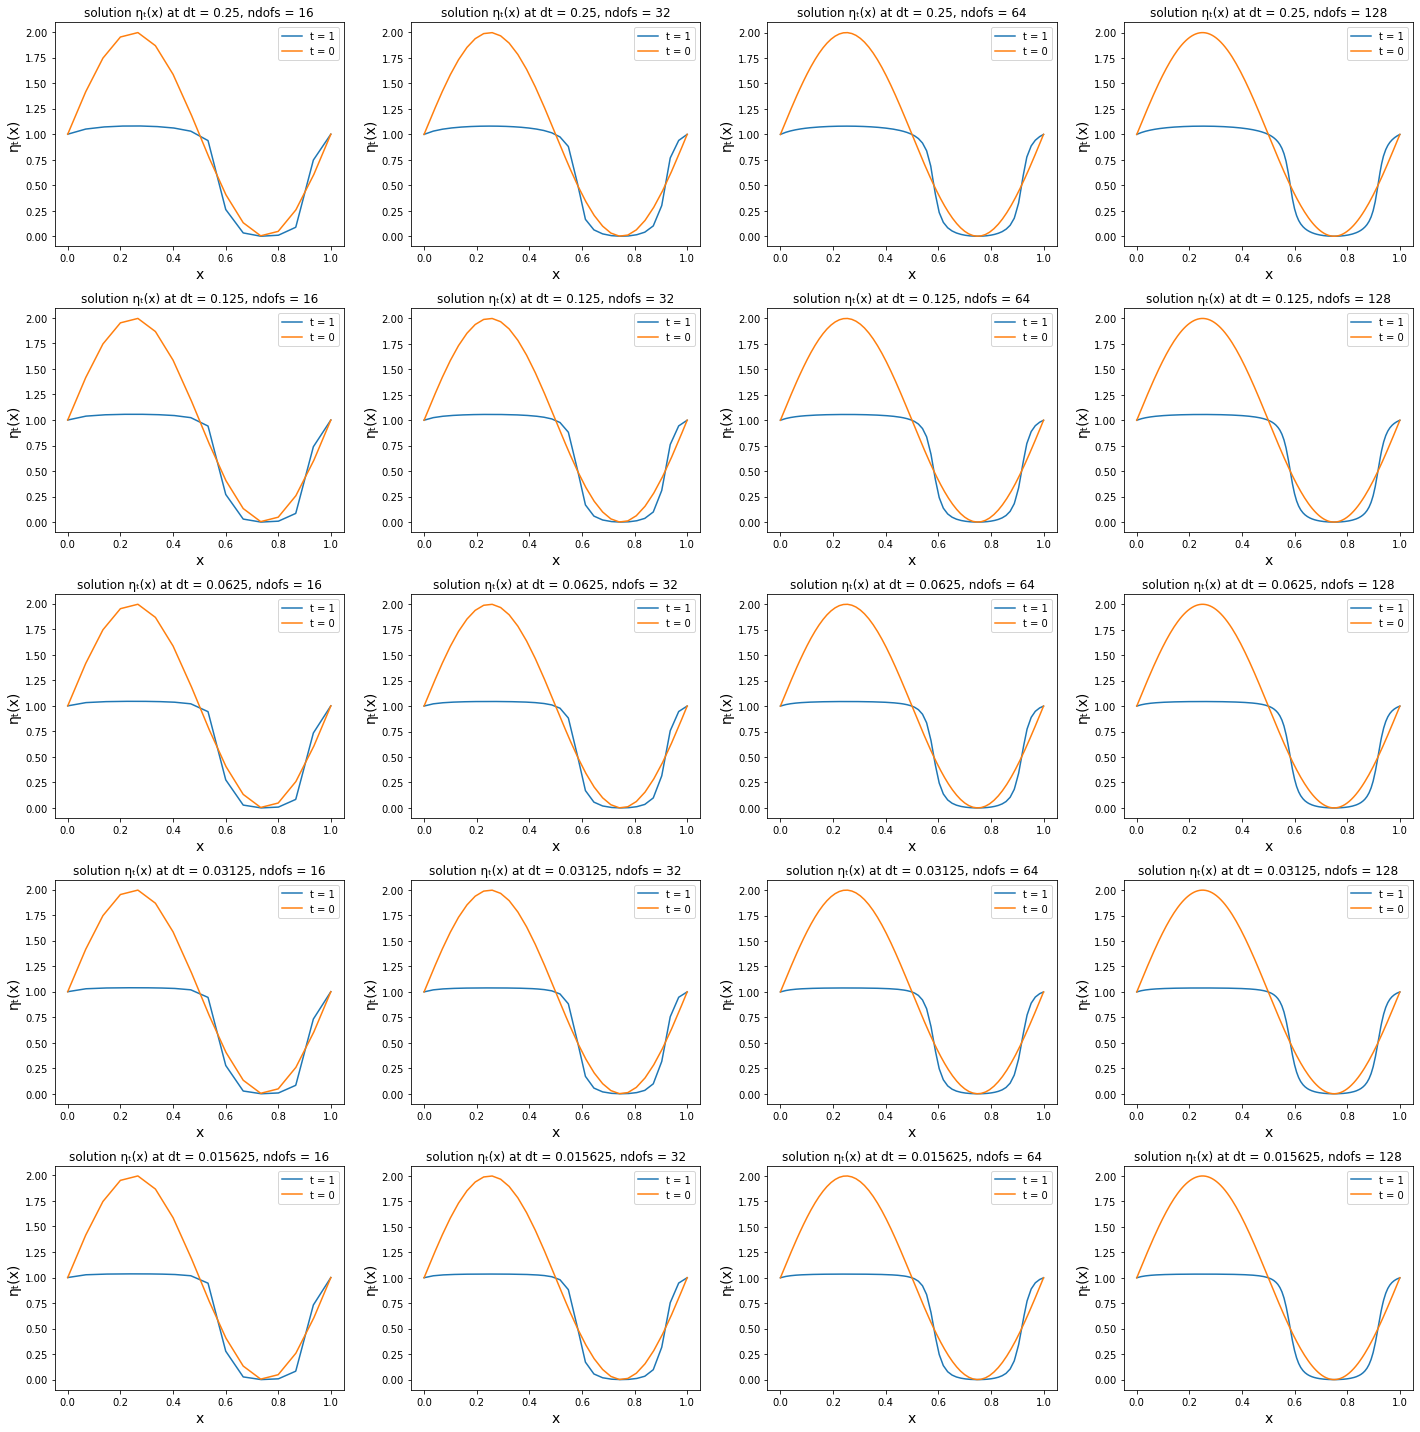

In [25]:
eps = 0.001
degree = 1
resolution = 1025

nonlinear_solutions(eps, degree, resolution, initial = True)

						  NON-LINEAR SOLUTION AT eps = 0.01, degree = 2  



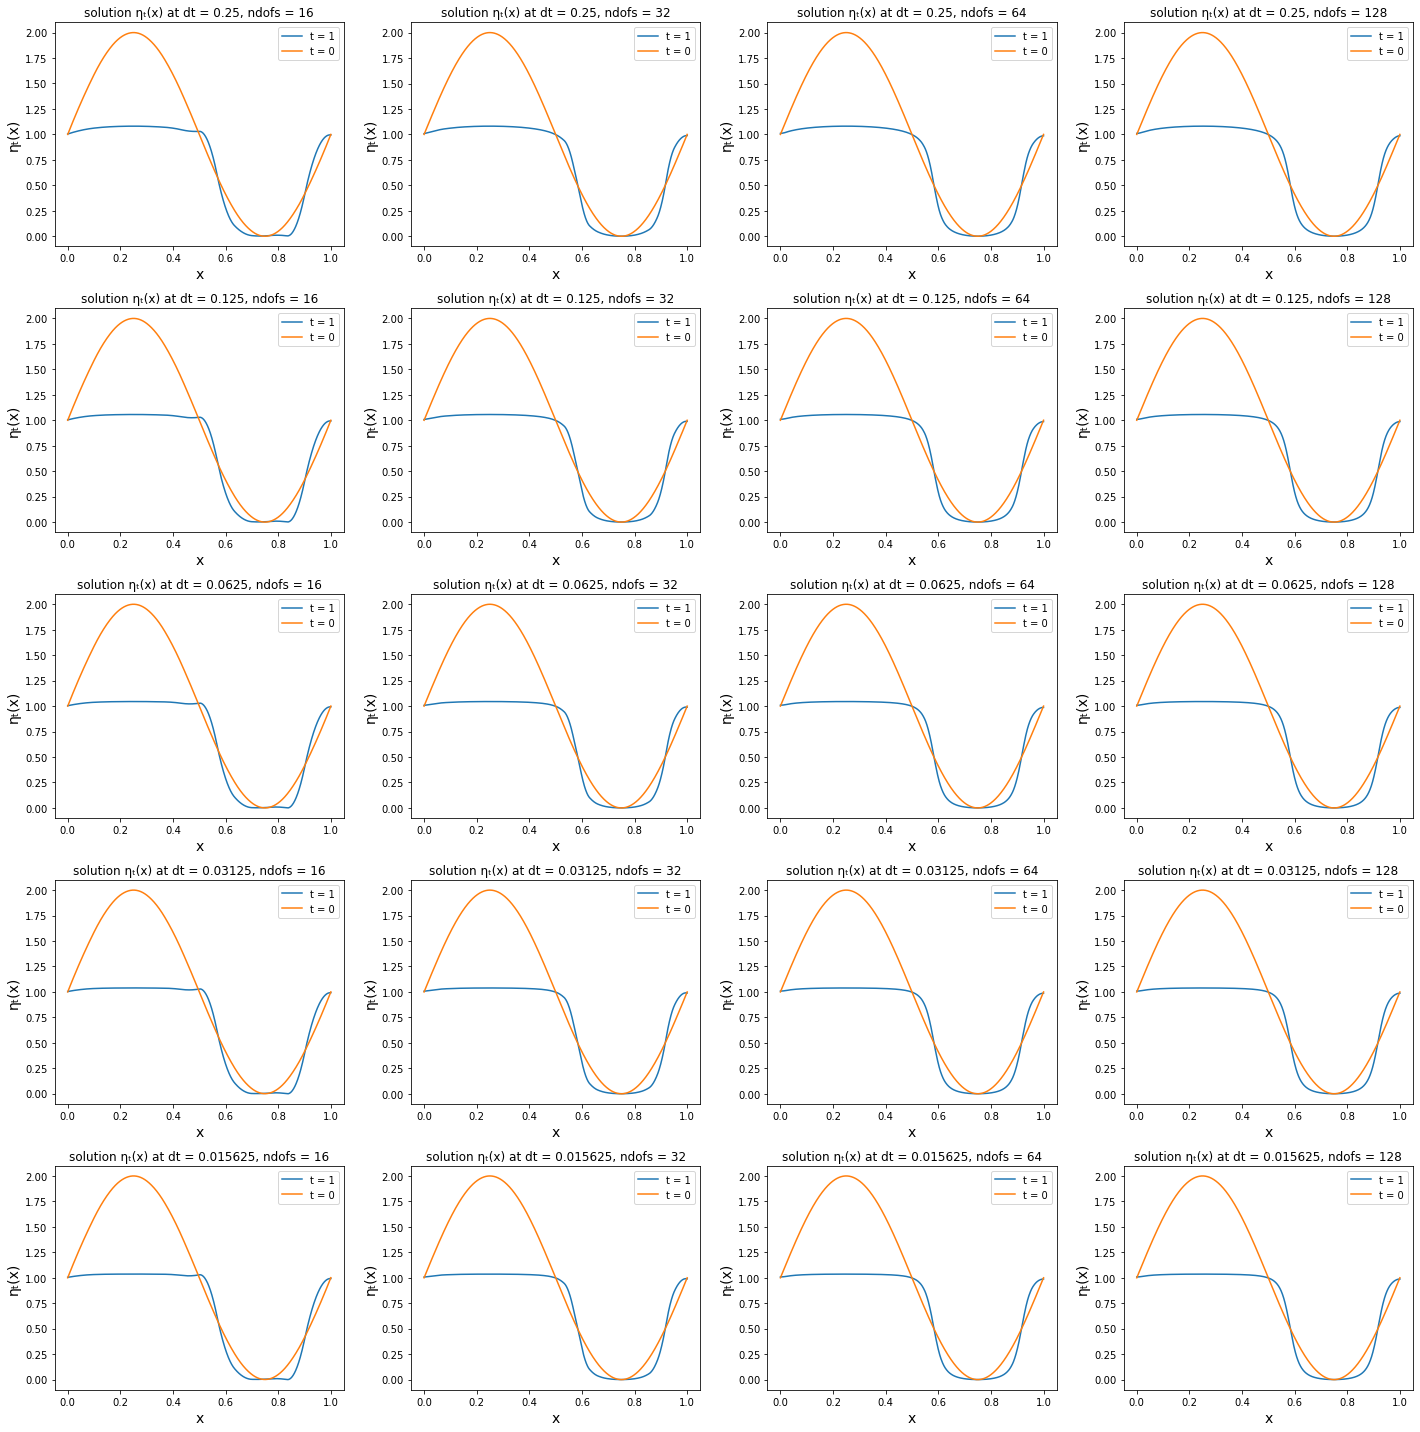

In [26]:
eps = 0.01
degree = 2
resolution = 1025

nonlinear_solutions(eps, degree, resolution, initial = True)

						  NON-LINEAR SOLUTION AT eps = 0.001, degree = 2  



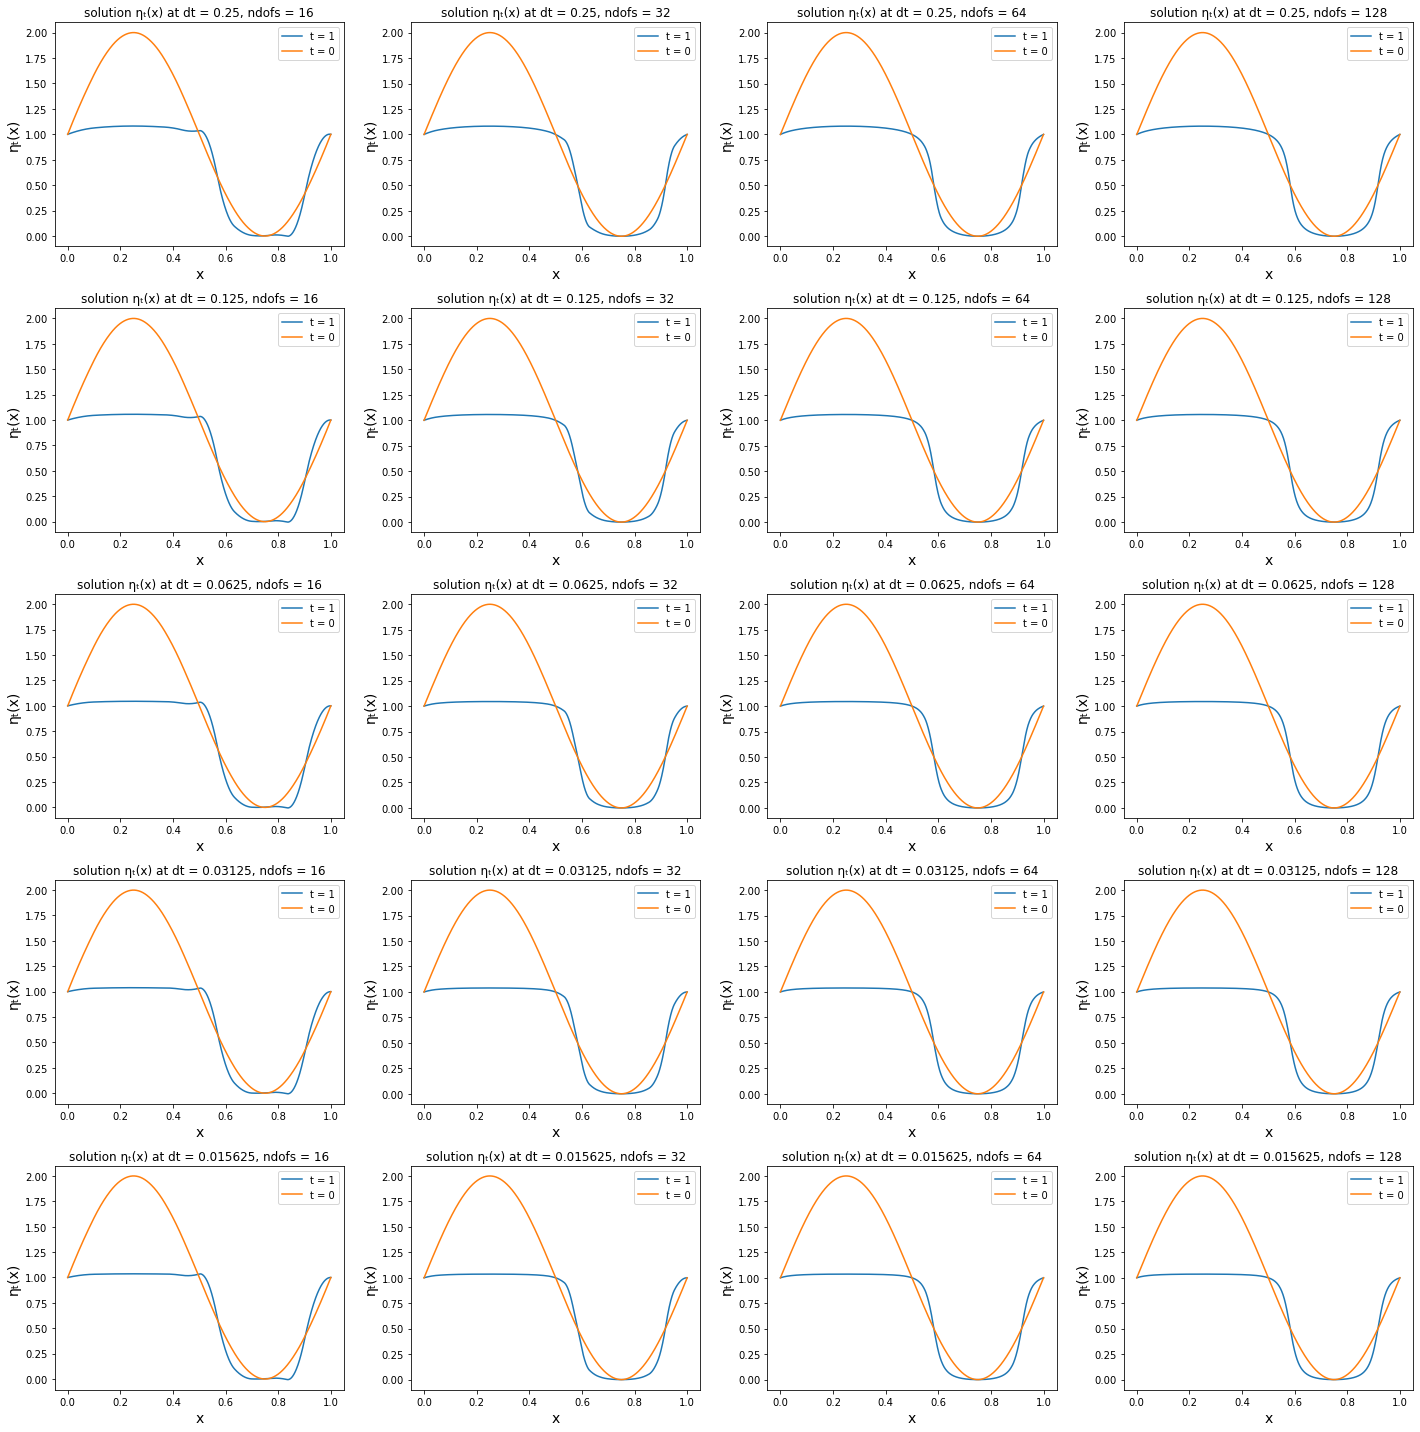

In [27]:
eps = 0.001
degree = 2
resolution = 1025

nonlinear_solutions(eps, degree, resolution, initial = True)

						  NON-LINEAR SOLUTION AT eps = 0.01, degree = 3  



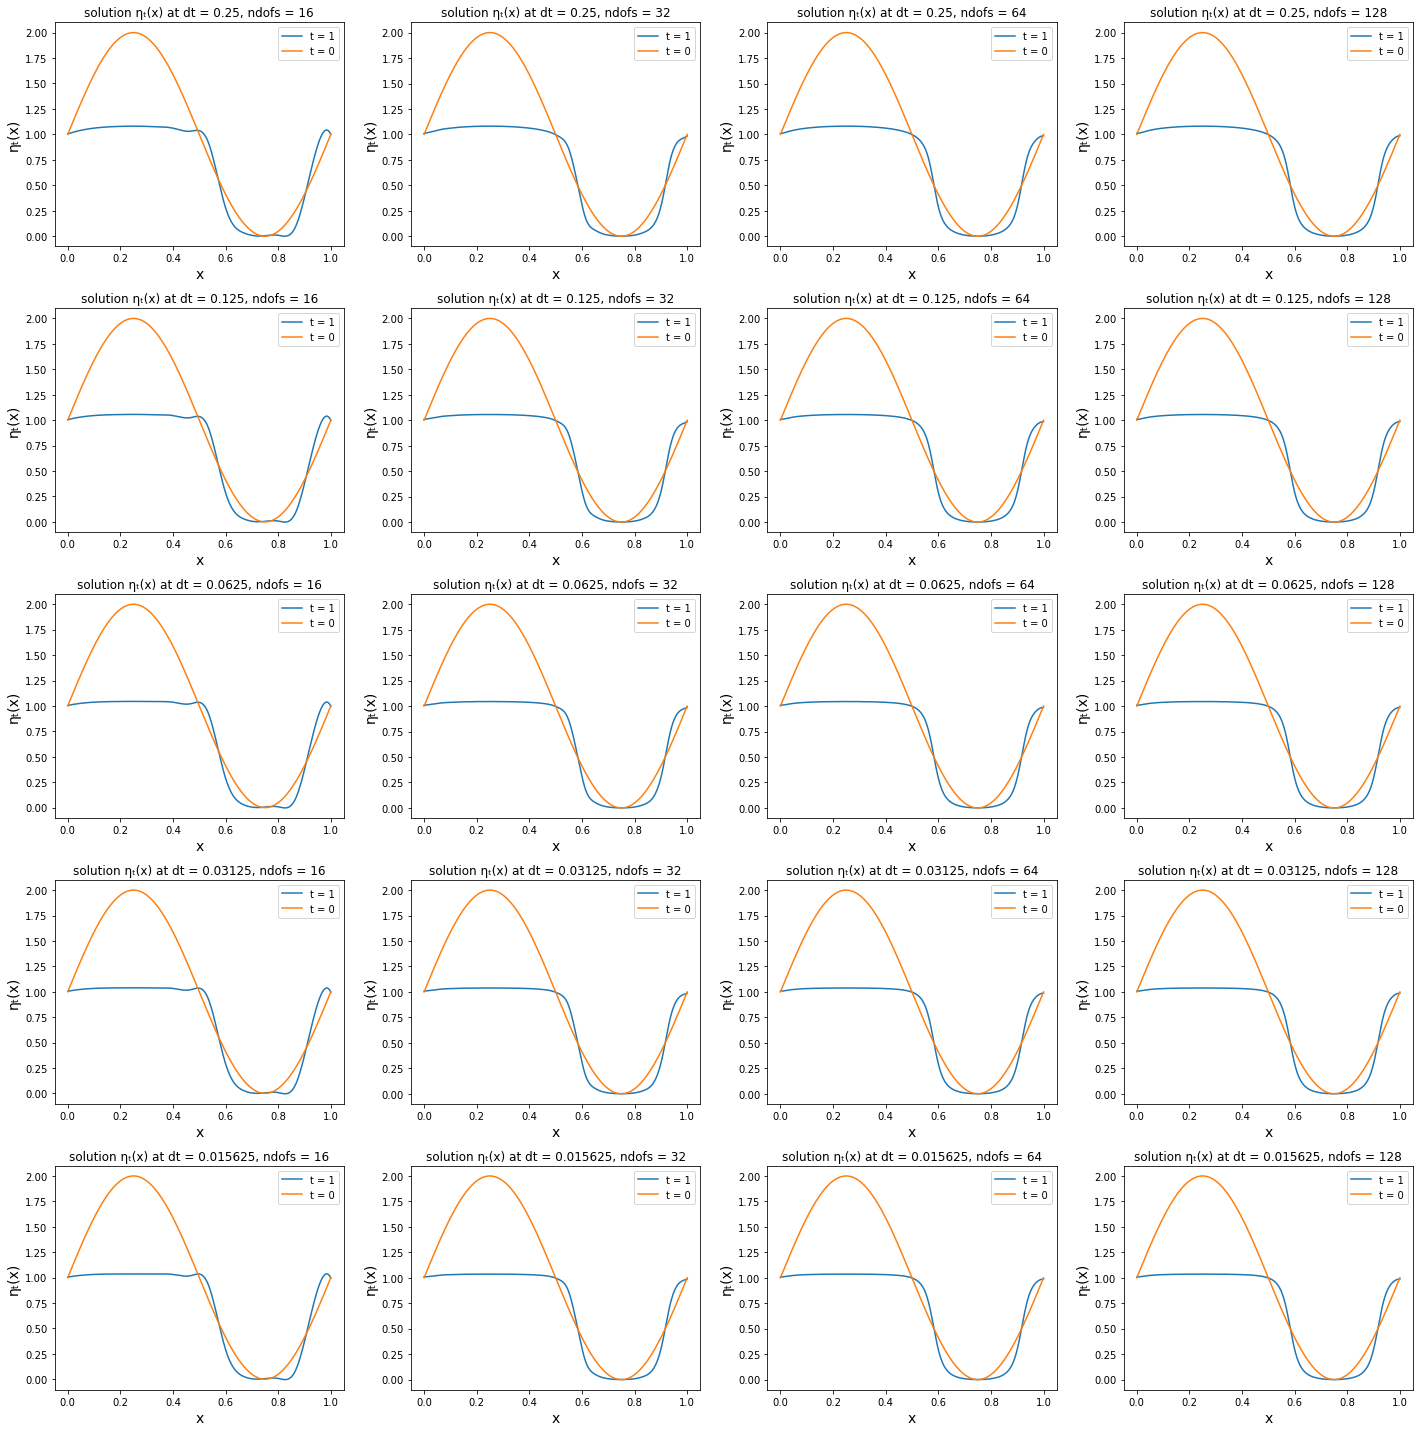

In [28]:
eps = 0.01
degree = 3
resolution = 1025

nonlinear_solutions(eps, degree, resolution, initial = True)

						  NON-LINEAR SOLUTION AT eps = 0.001, degree = 3  



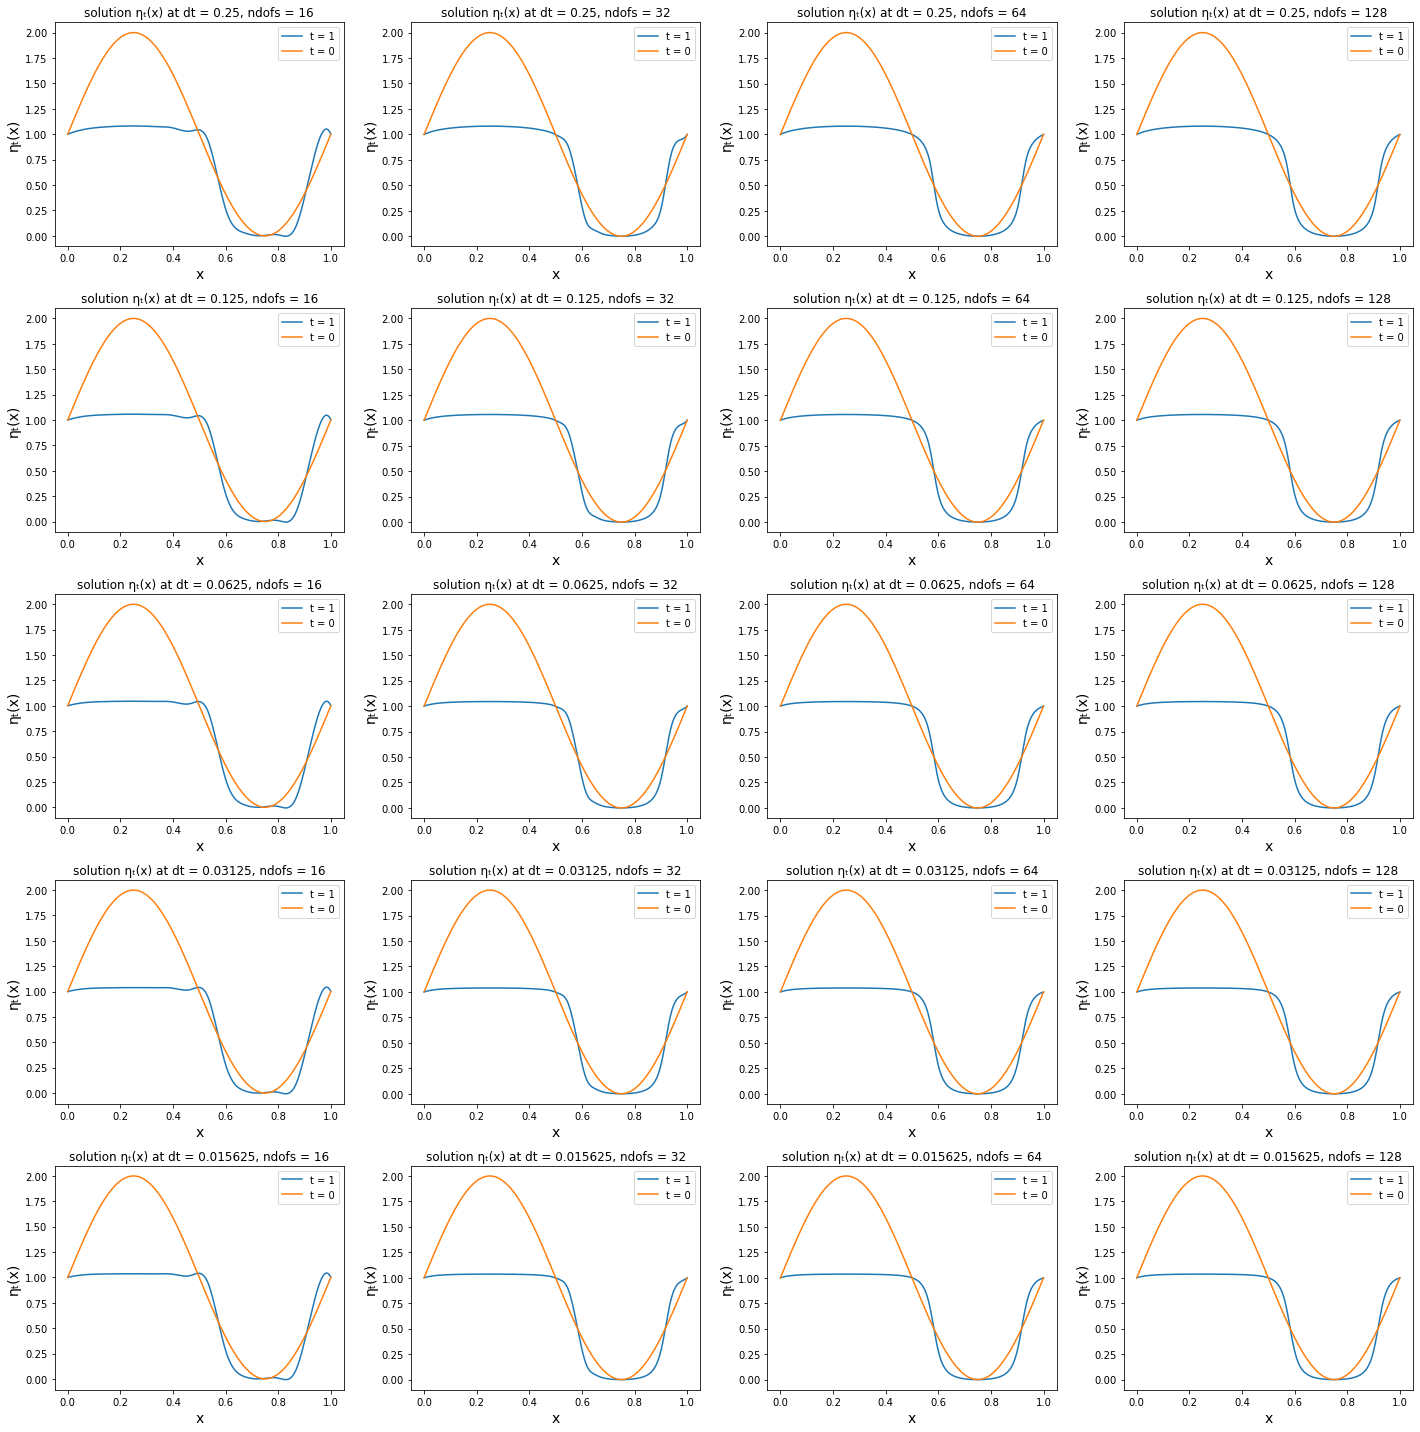

In [29]:
eps = 0.001
degree = 3
resolution = 1025

nonlinear_solutions(eps, degree, resolution, initial = True)

From these plots we notice that, differently from before, the solution converges also for large $\Delta t$: this is because the backward Euler method is unconditionally stable.